In [1]:
import selfies as sf
import pandas as pd
import difflib
import numpy as np
from collections import Counter

In [2]:
def tokenizer(mol,mol_encoding='selfies'):
    if mol_encoding=='smiles':
        "Tokenizes SMILES string"
        pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
        regezz = re.compile(pattern)
        tokens = [token for token in regezz.findall(mol)]
    elif mol_encoding=='selfies':
        tokens=[block+"]" for block in mol.split("]")][:-1]
    else:
        raise NameError('expected mol encoding to be smiles or selfies')
    assert mol == ''.join(tokens), ("{} could not be joined".format(mol))
    return tokens

In [3]:
def get_unmatched_toks(selfie, stable_selfie):
    s = difflib.SequenceMatcher(None, tokenizer(selfie), tokenizer(stable_selfie))
    unused_toks = []
    start = 0
    cur_b = 0
    for match in s.get_matching_blocks():
        if match.a != 0: #after first match
            selfie_missing = [i for i in range(start, match.a)]
            if selfie_missing: #not empty
                if cur_b != match.b:
                    stable_missing = [i for i in range(cur_b, match.b)]
                else:
                    stable_missing = []
                unused_toks.append((selfie_missing, stable_missing))
        start = match.a + match.size
        cur_b = match.b + match.size
    return unused_toks

In [10]:
def identify_situation(unused_toks, selfie, stable_selfie):
    cases = [0, 0, 0, 0, 0]
    annotation = annotateSelfie(selfie)
    stable_annotation = annotateSelfie(stable_selfie)
    for toks, stable_toks in unused_toks:
        if toks:
            l1 = [annotation[i] for i in toks]
        else:
            l1 = []
        if stable_toks: 
            l2 = [stable_annotation[i] for i in stable_toks]
        else:
            l2 = []
        print(l1)
        print(l2)
        if all(i == "n" for i in l1) and all(i == "n" for i in l2): #case 1
            cases[0] +=1
        elif l1[0] == "b" and all(i == "n" for i in l1[1:]) and not l2: #case 2
            cases[1] +=1
        elif l1[0] == "r" and all(i == "n" for i in l1[1:]) and not l2: #case 3
            cases[2] +=1
        elif l1[-1] == len(tokenizer(selfie))-1 and not l2:#truncation
            cases[4] += 1
        else:
            print("unidentified case")
            print((toks, stable_toks))
            print((l1, l2))

In [4]:
def get_num(token):
    return int(token[-2])

In [45]:
def annotateSelfie(selfie):
    tokens = tokenizer(selfie)

    i = 0
    annotation = [0 for i in range(len(tokens))]
    while i < len(tokens):
        tok = tokens[i]
        do_nums = False
        if tok in ["[=Branch1]", "[Branch1]", "[#Branch1]", "[Branch2]", "[#Branch2]", "[=Branch2]"]:
            annotation[i] = "b" #branch
            do_nums = True
        elif tok in ["[Ring1]", "[Ring2]", "[=Ring1]", "[=Ring2]"]:
            annotation[i] = "r" #ring
            do_nums = True
        else: 
            annotation[i] = "a" #atom
        if do_nums:
            num = get_num(tok)
            for j in range(min(num, len(tokens)-i-1)):
                annotation[i+j+1] = "n"
            i+=num
        i+=1
    return annotation

In [ ]:
samples = pd.read_csv("samples/sampled_selfies.csv")
num_truncated = 0
num_changed = 0
num_changed_sections = 0
extra_ring = 0
percent_changed = []
percent_deleted = []
percent_truncated = []
changed_toks = []
first_toks_trunc = []
for i, row in samples.iterrows():
    if i % 30000 == 0:
        print(i)
    selfie = row["sampled selfie"]
    stable_selfie = row["stable selfie"]
    if selfie != stable_selfie: num_changed +=1
    if selfie != stable_selfie and "_" not in selfie:
        selfie_toks = tokenizer(selfie)
        selfie_annot = annotateSelfie(selfie)
        stable_annot = annotateSelfie(stable_selfie)
        unused_toks = get_unmatched_toks(selfie, stable_selfie)

        #check for truncation
        last_mismatch = unused_toks[-1]
        selfie_ids = last_mismatch[0]
        stable_ids = last_mismatch[1]
        if selfie_ids[-1] == len(selfie_toks) - 1 and not stable_ids: #is truncated
            num_truncated +=1
            first_toks_trunc.append(selfie_annot[selfie_ids[0]])
            percent_truncated.append(len(selfie_ids)/len(selfie_toks))
        
        temp = []
        for toks in unused_toks:
            temp1 = [selfie_annot[i] for i in toks[0]]
            temp += temp1
            temp2 = [stable_annot[i] for i in toks[1]]
            if temp == ['b', 'n'] and temp2 == ['r', 'n']:
                extra_ring += 1
            num_changed_sections +=1
    
        percent_changed.append(len(temp)/len(selfie_toks))
        changed_toks += temp
        percent_deleted.append(1-len(tokenizer(stable_selfie))/len(selfie_toks))

print("Fraction of each selfie changed" + str(np.mean(percent_changed)))
print("Fraction of each selfie deleted" + str(np.mean(percent_deleted)))
print("Perfect of selfies which are truly trunctated (ie lose atoms)" + str(np.mean(percent_truncated)))
c1 = Counter(first_toks_trunc)
print("Number of tokens of each type at start of truncated section:")
print(c1)
c2 = Counter(changed_toks)
print("Number of tokens of each type at start of changed section:")
print(c2)
print("Number of truncated mols" + str(num_truncated))
print("Number of changed mols" + str(num_changed))
print("Number of changed sections" + str(num_changed_sections))
print("Number of time a branch is changed into a ring" + str(extra_ring))
    
        

In [ ]:
from rdkit import Chem

samples = pd.read_csv("samples/sampled_selfies.csv")
samples = samples[samples["augmented"] == False] #only unstable selfies will have different number of rings/branches
num_rings_deleted = []
num_branches_deleted = []
atom_swaps = []
atom_deletes = []
num_swaps = []
r_b_both_del = 0
non_r_b_mols = 0 #num of selfies with same number of ring/branch as stable selfie
prob = 0

z = Counter()


for i, row in samples.iterrows():
    selfie = row["sampled selfie"]
    stable = row["stable selfie"]
    
    try:
        #selfies num rings
        
        sf_annots = ''.join(annotateSelfie(selfie))
        sf_num_rings = sf_annots.count('r')
        sf_num_branches = sf_annots.count('b')

        #stable num rings
        st_annots = ''.join(annotateSelfie(stable))
        st_num_rings = st_annots.count('r')
        st_num_branches = st_annots.count('b')
        
        num_rings_deleted.append(sf_num_rings - st_num_rings)
        num_branches_deleted.append(sf_num_branches - st_num_branches)
        if sf_num_rings - st_num_rings > 0 and sf_num_branches - st_num_branches > 0:
            r_b_both_del +=1
        if sf_num_rings == st_num_rings and sf_num_branches == st_num_branches:
            non_r_b_mols +=1
            unused_toks = get_unmatched_toks(selfie, stable)
            #if len(st_annots) == len(sf_annots):
            swapped = [repr(([sf_annots[i] for i in toks[0]], [st_annots[i] for i in toks[1]]))  for toks in unused_toks]
            c = Counter()
            c.update(swapped)
            z.update(swapped)
            num_swap = c.get("(['n'], ['n'])", 0)
            num_swaps.append(num_swap)
            atom_swap = c.get("(['a'], ['a'])", 0)
            atom_swaps.append(atom_swap)
            atom_delete = c.get("(['a'], [])", 0)
            atom_deletes.append(atom_delete)
                #for toks in unused_toks:
                    #if len(toks[0]) == 1 and len(toks[1]) == 1:
                        #if toks[0][0] == 'a' and toks[1][0] == 'a':
                #swapped = [([sf_annots[i] for i in toks[0]], [st_annots[i] for i in toks[1]])  for toks in unused_toks]
                #print(swapped)
    except:
        prob+=1
        pass
    

In [47]:

print("Swaps collected:")
print(z.most_common(20))
print("\n")
print("Total number of mols: " + str(len(samples)))
print("Fraction of mols with no branch/ring # change: " + str(non_r_b_mols/len(samples)))
num_mols_numswap = len([swap for swap in num_swaps if swap>0])
print("Fraction of mols (with no branch/ring # change) with number swap: " + str(num_mols_numswap/non_r_b_mols))
num_mols_atomswap = len([swap for swap in atom_swaps if swap>0])
print("Fraction of mols (with no branch/ring # change) with atom swap: " + str(num_mols_atomswap/non_r_b_mols))
num_mols_atomsdel = len([delete for delete in atom_deletes if delete>0])
print("Fraction of mols (with no branch/ring # change) with atom deletion: " + str(num_mols_atomsdel/non_r_b_mols))

count = 0
for i in range(non_r_b_mols):
    if num_swaps[i]==0 and atom_swaps[i]==0 and atom_deletes[i]==0:
        count+=1
print("Fraction of mols (with no branch/ring # change) with no atom/num swap or atom delete: " + str(count/non_r_b_mols))

print("Number of mols that threw errors: " + str(prob))



Swaps collected:
[("(['n'], ['n'])", 22833), ("(['a'], [])", 7278), ("(['a'], ['a'])", 7129), ("(['r', 'n', 'a'], ['a'])", 685), ("(['b', 'n'], ['b', 'n', 'n'])", 680), ("(['b', 'n', 'n'], ['b', 'n'])", 650), ("(['b'], ['b'])", 538), ("(['r'], [])", 459), ("(['a', 'a'], [])", 441), ("(['r', 'n'], [])", 407), ("(['a', 'a'], ['a'])", 250), ("(['a', 'r', 'n', 'n'], [])", 148), ("(['r', 'n', 'n'], [])", 128), ("(['a', 'r', 'n'], [])", 70), ("(['r', 'n', 'n', 'a'], ['a'])", 62), ("(['a', 'r', 'n', 'a'], ['a', 'a'])", 58), ("(['a', 'a'], ['a', 'a'])", 53), ("(['a', 'a', 'a'], [])", 45), ("(['n'], [])", 41), ("(['n', 'a'], ['n'])", 38)]


Total number of mols: 171757
Fraction of mols with no branch/ring # change: 0.18669981427248963
Fraction of mols (with no branch/ring # change) with number swap: 0.667602207877257
Fraction of mols (with no branch/ring # change) with atom swap: 0.2186359809149593
Fraction of mols (with no branch/ring # change) with atom deletion: 0.22381264228022577
Fraction 

In [48]:
#Counting number of molecules with rings deleted
rings_deleted = Counter()
rings_deleted.update(num_rings_deleted)
print(rings_deleted)
num_unstable_selfies = len(samples[samples["augmented"] == False])
num_mols_lost_ring = sum([v for k,v in rings_deleted.items() if k > 0])
num_mols_ring_change = sum([v for k,v in rings_deleted.items() if k != 0])
total = sum([v for k,v in rings_deleted.items()])
print("Fraction (out of all valid selfies) of mols that lose rings: " + str(num_mols_lost_ring/total))
print("Fraction (out of all unstable selfies) of mols that lose rings: " + str(num_mols_lost_ring/num_unstable_selfies))
print("Fraction (out of all unstable selfies) of mols that lose/gain rings: " + str(num_mols_ring_change/num_unstable_selfies))

Counter({1: 97558, 0: 52466, 2: 19581, 3: 2011, 4: 114, -1: 11, 5: 2})
Fraction (out of all valid selfies) of mols that lose rings: 0.6944446061848226
Fraction (out of all unstable selfies) of mols that lose rings: 0.6943880016534988
Fraction (out of all unstable selfies) of mols that lose/gain rings: 0.6944520456225947


In [49]:
#Counting number of molecules with branched deleted
branches_deleted = Counter()
branches_deleted.update(num_branches_deleted)
print(branches_deleted)
num_mols = sum([v for k,v in branches_deleted.items() if k > 0])
total = sum([v for k,v in branches_deleted.items()])
num_mols_branch_change = sum([v for k,v in branches_deleted.items() if k != 0])
print("Fraction (out of all valid selfies) of mols that lose branches: " + str(num_mols/total))
print("Fraction (out of all unstable selfies) of mols that lose branches: " + str(num_mols/num_unstable_selfies))
print("Fraction (out of all unstable selfies) of mols that lose/gain branche: " + str(num_mols_branch_change/num_unstable_selfies))


Counter({0: 134956, 1: 32832, 2: 3141, 3: 571, 4: 173, 5: 47, 6: 14, -1: 8, 7: 1})
Fraction (out of all valid selfies) of mols that lose branches: 0.2141513773487129
Fraction (out of all unstable selfies) of mols that lose branches: 0.2141339217615585
Fraction (out of all unstable selfies) of mols that lose/gain branche: 0.21418049919362822


In [50]:
print("Fraction of unstable selfies losing both rings and branches: " + str(r_b_both_del/num_unstable_selfies))

Fraction of unstable selfies losing both rings and branches: 0.09530324819366896


In [ ]:
#printing alignment to looks for examples of 6 cases

samples = pd.read_csv("samples/sampled_selfies.csv")
for i, row in samples.iterrows():
    selfie = row["sampled selfie"]
    stable_selfie = row["stable selfie"]
    print(selfie)
    print(stable_selfie)
    if selfie != stable_selfie and "_" not in selfie:
        unused_toks = get_unmatched_toks(selfie, stable_selfie)
        print(unused_toks)
        identify_situation(unused_toks, selfie, stable_selfie)


In [44]:
sf = "[O][=S][=Branch1][C][=O][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][C][=C][Branch1][=C][C][=C][C][=C][N][=C][Ring1][=Branch1][C][Ring1] [#Branch2][Ring1][#Branch2][C][Ring1][#C]"
annot = annotateSelfie(sf)
print(annot)

st = "[O][=S][=Branch1][C][=O][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][N][C][C][=C][Branch1][N] [C][=C][C][=C][N][=C][Ring1][=Branch1][C][=Ring1][#Branch2][C][Ring1][#C]"
annot = annotateSelfie(st)
print(annot)

['a', 'a', 'b', 'n', 'a', 'b', 'n', 'a', 'a', 'a', 'a', 'a', 'a', 'r', 'n', 'a', 'a', 'a', 'a', 'b', 'n', 'a', 'a', 'a', 'a', 'a', 'a', 'r', 'n', 'a', 'r', 'n', 'r', 'n', 'a', 'r', 'n']
['a', 'a', 'b', 'n', 'a', 'b', 'n', 'a', 'a', 'a', 'a', 'a', 'a', 'r', 'n', 'a', 'a', 'a', 'a', 'b', 'n', 'a', 'a', 'a', 'a', 'a', 'a', 'r', 'n', 'a', 'a', 'b', 'n', 'n', 'a']


In [6]:
############## Everything below is just for visualizing sampled molecules ###############

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

C1C(=O)C=C1CCCN(C(=O)NCC)C
4


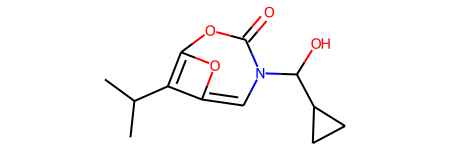

In [9]:
selfie="[C][C][=Branch1][C][=O][C][=C][Branch1][P][C][C][C][N][Branch1][#Branch2][C][=Branch1][C][=O][N][C][C][Ring1][Branch1][C][Ring1][#Branch2]"
smi=sf.decoder(selfie)
print(smi)
mol=Chem.MolFromSmiles("CC(C)C1=C2OC(=O)N(C(O)C3CC3)C=C1O2")
ssr=Chem.GetSymmSSSR(mol)
print(len(ssr))
mol

C1C(=O)C=C1CCCN(C(=O)NCC)C


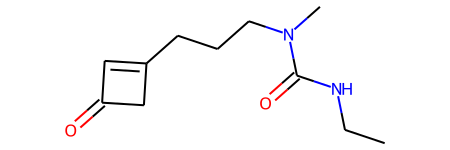

In [18]:
selfie="[C][C][=Branch1][C][=O][C][=C][Ring1][Branch1][C][C][C][N][Branch1][Branch2][C][=Branch1][C][=O][N][C][C][C]"
smi=sf.decoder(selfie)
print(smi)
mol=Chem.MolFromSmiles(smi)
mol

In [33]:
selfie = "[C][O][C][C][=Branch1][C][=O][N][C][C][O][C][Branch1][S][S][C][C][=Branch1][C][=O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Ring1][S]"
smi, attr_map = sf.decoder(selfie, attribute=True)

print(attr_map)
print(smi)

[AttributionMap(index=0, token='C', attribution=[Attribution(index=0, token='[C]')]), AttributionMap(index=4, token='O', attribution=[Attribution(index=1, token='[O]')]), AttributionMap(index=6, token='C', attribution=[Attribution(index=2, token='[C]')]), AttributionMap(index=8, token='C', attribution=[Attribution(index=3, token='[C]')]), AttributionMap(index=10, token='=', attribution=[Attribution(index=4, token='[=Branch1]'), Attribution(index=6, token='[=O]')]), AttributionMap(index=11, token='O', attribution=[Attribution(index=4, token='[=Branch1]'), Attribution(index=6, token='[=O]')]), AttributionMap(index=14, token='N', attribution=[Attribution(index=7, token='[N]')]), AttributionMap(index=16, token='C', attribution=[Attribution(index=8, token='[C]')]), AttributionMap(index=18, token='C', attribution=[Attribution(index=9, token='[C]')]), AttributionMap(index=20, token='O', attribution=[Attribution(index=10, token='[O]')]), AttributionMap(index=22, token='C', attribution=[Attribu

In [9]:
toks = ['b', 'n']
print('b' in toks )

True
